In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [139]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

### VQ-VAE 
(Vector Quantized Variational Autoencoder) has several advantages over traditional VAEs (Variational Autoencoders). The key advantages of VQ-VAE over VAE are:

$\bullet$ ***Discrete Latent Representation: VQ-VAE learns a discrete latent representation, whereas VAE learns a continuous latent representation***

$\bullet$ ***Learned Prior: In VQ-VAE, the prior is learned rather than static, which helps in circumventing issues of "posterior collapse"***

These differences allow VQ-VAE to better represent diverse and complex data distributions, making it a popular component in the deep learning ecosystem
The use of vector quantization in VQ-VAE helps improve the model in a rigorous way, particularly by addressing issues such as posterior collapse.


# Model definition

In [140]:
class codebook(nn.Module):
    def __init__(self, codebook_dim, codebook_size):
        super(codebook, self).__init__()
        self.codebook = nn.Embedding(codebook_size, codebook_dim) # Tricking the torch to use tensor as parameter
        
        with torch.no_grad():
            self.codebook.weight.fill_(0.5)

    def forward(self, z_e):

        distances = torch.norm(z_e[:, :, None, :] - self.codebook.weight[None, :, :], dim=-1)
        indices = torch.argmin(distances, dim=-1)
        z_q = self.codebook.weight[indices].view(z_e.shape)

        return z_q


class VQVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, codebook_size, codebook_dim):
        super(VQVAE, self).__init__()
        self.latent_dim = latent_dim
        self.codebook_dim = codebook_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim[0], kernel_size=9, stride=4, padding=4),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_dim[0]),
            nn.Conv2d(hidden_dim[0], hidden_dim[1], kernel_size=5, stride=2, padding=3),
            nn.ReLU(),
            nn.Conv2d(hidden_dim[1], latent_dim*codebook_dim, kernel_size=3, stride=3, padding=0),
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim*codebook_dim, hidden_dim[1], kernel_size=3, stride=3, padding=0, output_padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim[1], hidden_dim[0], kernel_size=5, stride=2, padding=3, output_padding=1),
            nn.BatchNorm2d(hidden_dim[0]),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim[0], input_dim, kernel_size=9, stride=4, padding=5, output_padding=1),
            nn.Sigmoid()
        )
        self.codebook = codebook(codebook_dim, codebook_size)

    
    def forward(self, x):
        x = self.encoder(x)
        
        if len(x.shape) > 3:
            z_e = x.view(x.size(0), self.latent_dim, 1, self.codebook_dim).squeeze(-2)
            z_q = self.codebook(z_e)
            x = z_e + (self.codebook(z_e) - z_e).detach()
            x = x.view(x.size(0), self.latent_dim*self.codebook_dim, 1, 1)
        else :
            z_e = x.view(1, self.latent_dim, 1, self.codebook_dim)
            z_q = self.codebook(z_e)
            x = z_e + (z_q - z_e).detach()
            x = x.squeeze(0).view(self.latent_dim*self.codebook_dim, 1, 1)

        x = self.decoder(x)

        return x, z_e, z_q
    


# Model training

In [141]:
input_dim = 1  # Single-channel images for MNIST
hidden_dim = [64, 64]
latent_channels = 64  # Adjust as needed
codebook_size = 3
codebook_dim = 2
beta = 0.01

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vq_vae = VQVAE(input_dim, hidden_dim, latent_channels, codebook_size, codebook_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(vq_vae.parameters(), lr=0.001)

codebooks = []

Epoch [3/15], Train Loss: 0.0825, Val Loss: 0.0821


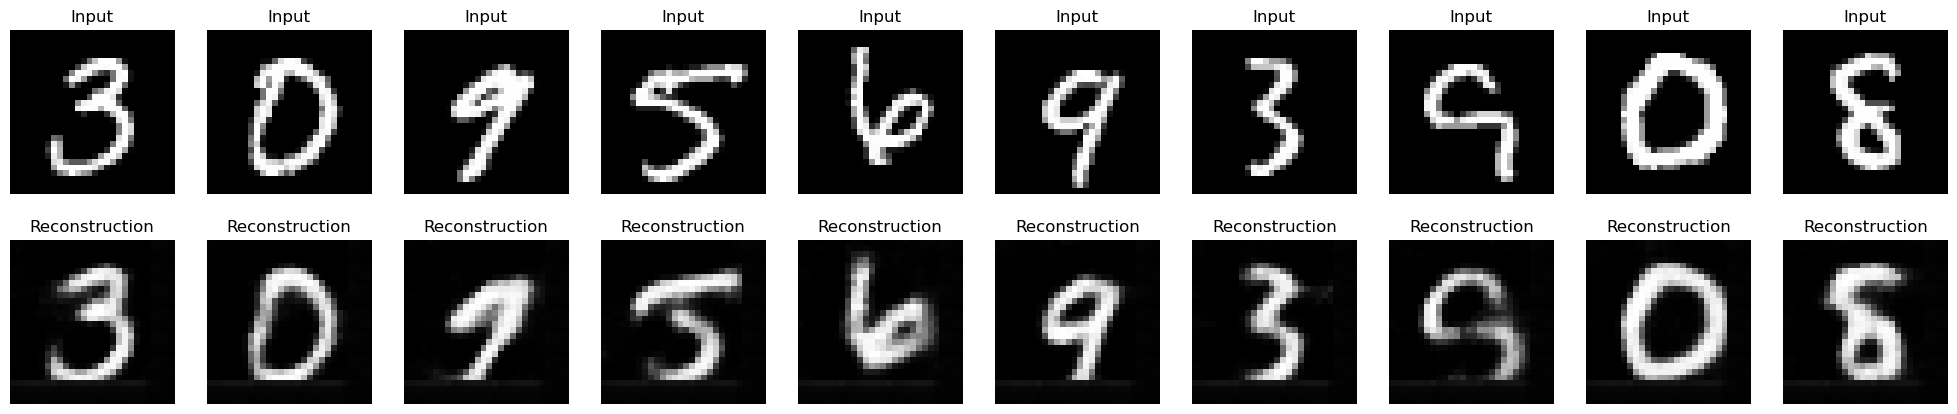

Epoch [6/15], Train Loss: 0.0819, Val Loss: 0.0821


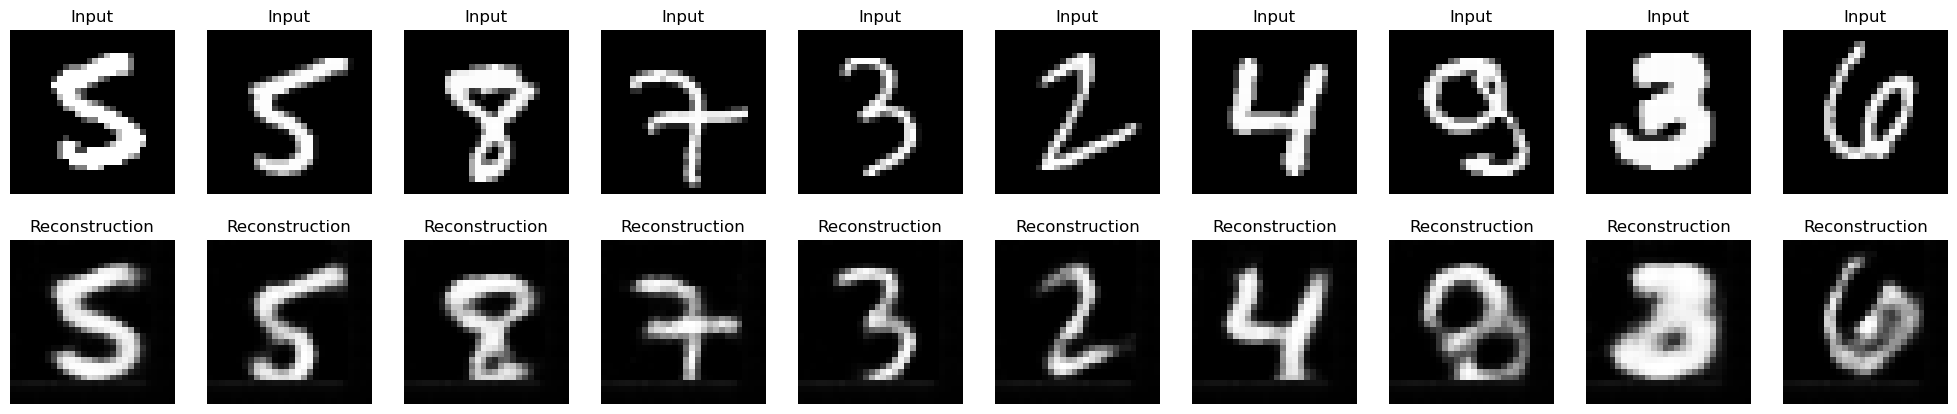

Epoch [9/15], Train Loss: 0.0821, Val Loss: 0.0825


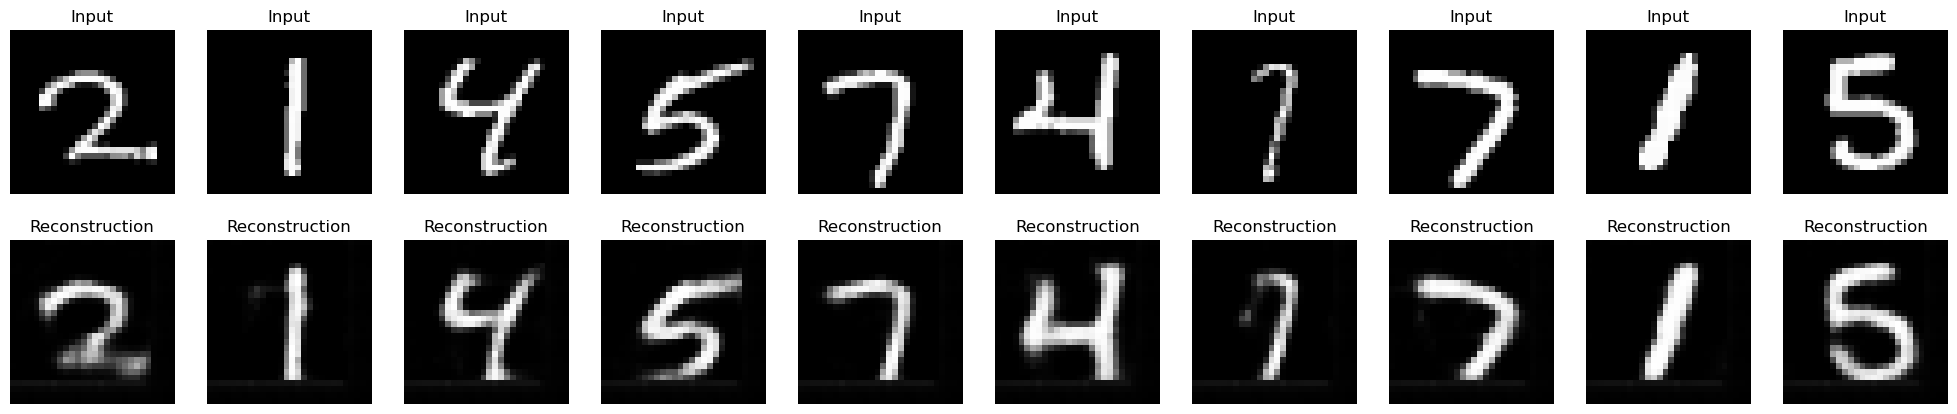

Epoch [12/15], Train Loss: 0.0824, Val Loss: 0.0828


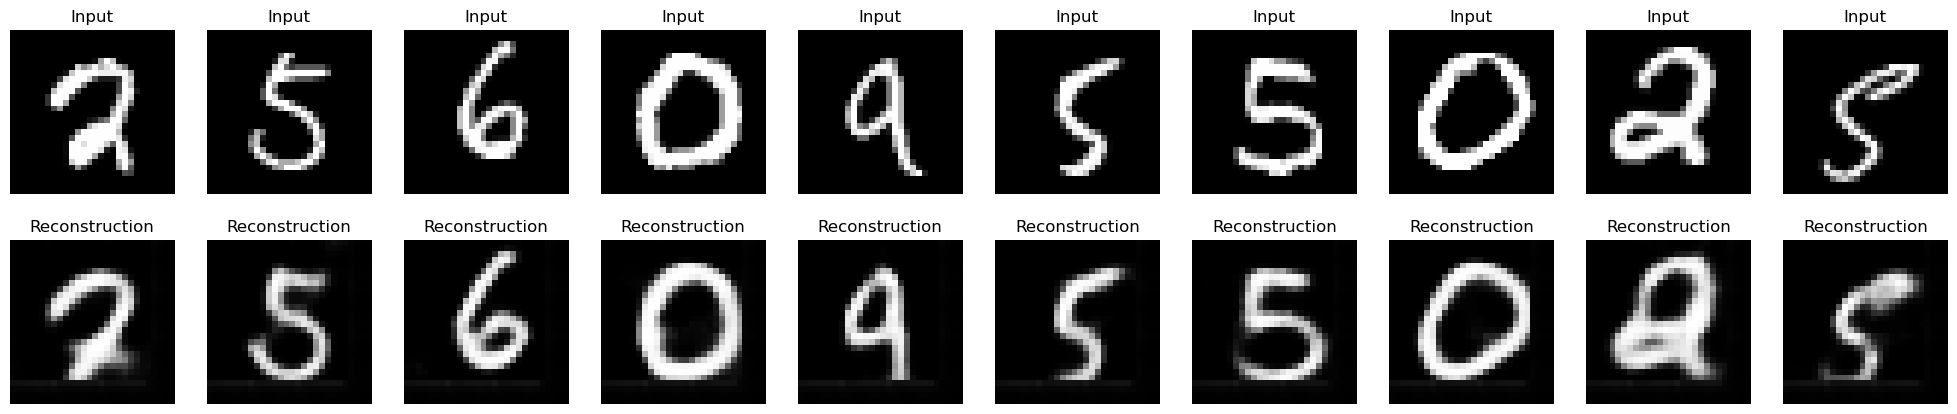

Epoch [15/15], Train Loss: 0.0829, Val Loss: 0.0831


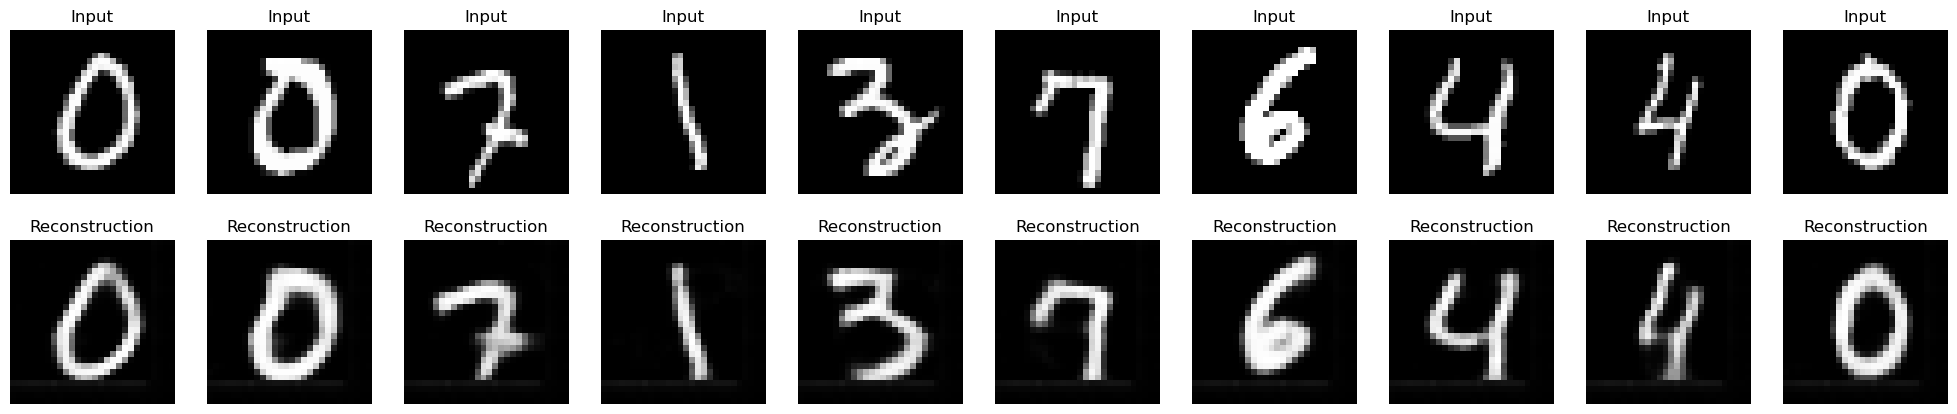

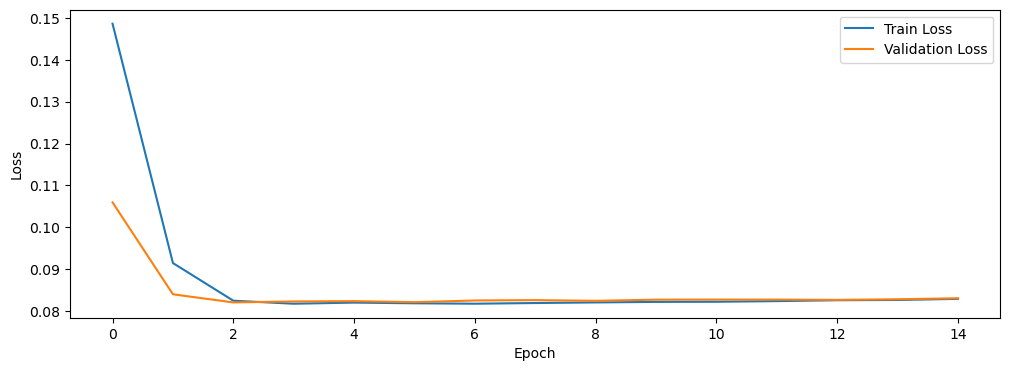

In [142]:

num_epochs = 15
num_samples = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs): 

    vq_vae.train()
    total_train_loss = 0.0
    total_train_loss = 0.0

    for batch_data, _ in train_loader:
        optimizer.zero_grad()
        batch_data = batch_data.to(device)
        # Forward pass
        recon, z_e, z_q = vq_vae(batch_data)
        
        loss = criterion(recon, batch_data) + criterion(z_e.detach(), z_q) + beta * criterion(z_e, z_q.detach())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        codebooks.append(vq_vae.codebook.codebook.weight.detach().cpu())

        total_train_loss += loss.item()

    # Print the loss for each epoch
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model = vq_vae
    model.eval()

        # Get a batch of data
    with torch.no_grad():

        total_val_loss = 0.0

        for batch_data, _ in test_loader:
            batch_data = batch_data.to(device)
            recon, z_e, z_q = vq_vae(batch_data)
            loss = criterion(recon, batch_data) + criterion(z_e.detach(), z_q) + beta * criterion(z_e, z_q.detach())

            total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        
        if (100 * (epoch+1) / num_epochs) % 20 == 0:

            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            
            data, _ = next(iter(test_loader))
            data = data.to(device)

            recon, _, _ = model(data)
        
            denormalized_data = (data + 1) / 2
            denormalized_reconstructions = (recon + 1) / 2

            plt.figure(figsize=(5*num_samples//2, 5))
            samples = torch.randint(0, data.size(0), (num_samples,))
            for i, s in enumerate(samples):
                plt.subplot(2, num_samples, i + 1)
                plt.imshow(denormalized_data[s][0].cpu(), cmap='gray')
                plt.title('Input')
                plt.axis('off')

                plt.subplot(2, num_samples, i + 1 + num_samples)
                plt.imshow(denormalized_reconstructions[s][0].cpu(), cmap='gray')
                plt.title('Reconstruction')
                plt.axis('off')

            plt.show()

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

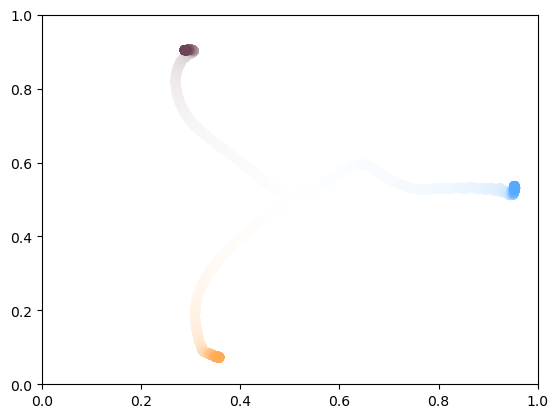

In [143]:
colors = torch.arange(0, 1, 1/codebook_size)
colors2 = colors.__reversed__()
colors3 = torch.rand(codebook_size) / 2 + 0.5
colors = torch.stack([colors, colors2, colors3]).view(-1, 3)

cbs = torch.stack(codebooks)

fig, ax = plt.subplots()

# Function to update the plot for each frame
def update(frame):
    ax.clear()
    plt.scatter(cbs[frame*10, :, 0], cbs[frame*10, :, 1], c=1-colors)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
# Create the animation
ani = FuncAnimation(fig, update, frames=cbs.shape[0]//10, repeat=False)

# Save the animation as a GIF
ani.save('animation.gif', writer='pillow', fps=30)

for i, cb in enumerate(cbs):
    plt.scatter(cb[:, 0], cb[:, 1], c=1-colors*(i / cbs.shape[0]))
plt.show()

# Increasing Codebook size (RGB data)

In [144]:
input_dim = 3  # Single-channel images for MNIST
hidden_dim = [64, 64]
latent_channels = 64  # Adjust as needed
codebook_size = 48 # 16x codebook size
codebook_dim = 2
beta = 0.01

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vq_vae = VQVAE(input_dim, hidden_dim, latent_channels, codebook_size, codebook_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(vq_vae.parameters(), lr=0.001)

codebooks = []

Epoch [3/15], Train Loss: 0.0097, Val Loss: 0.0077


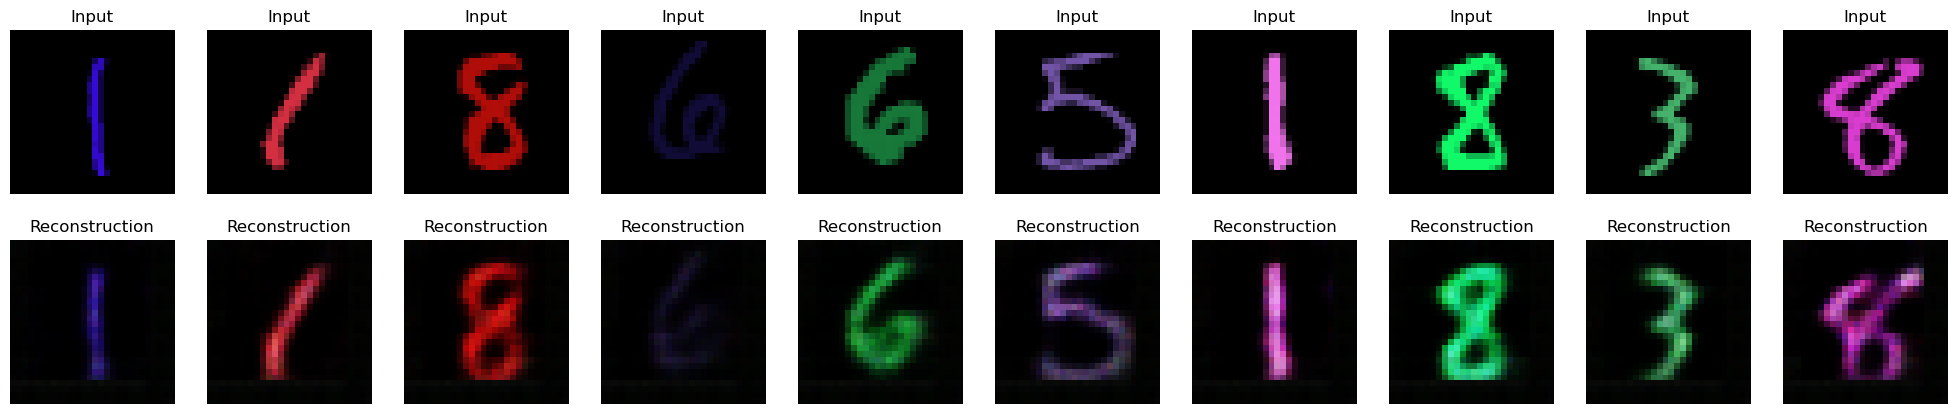

Epoch [6/15], Train Loss: 0.0059, Val Loss: 0.0056


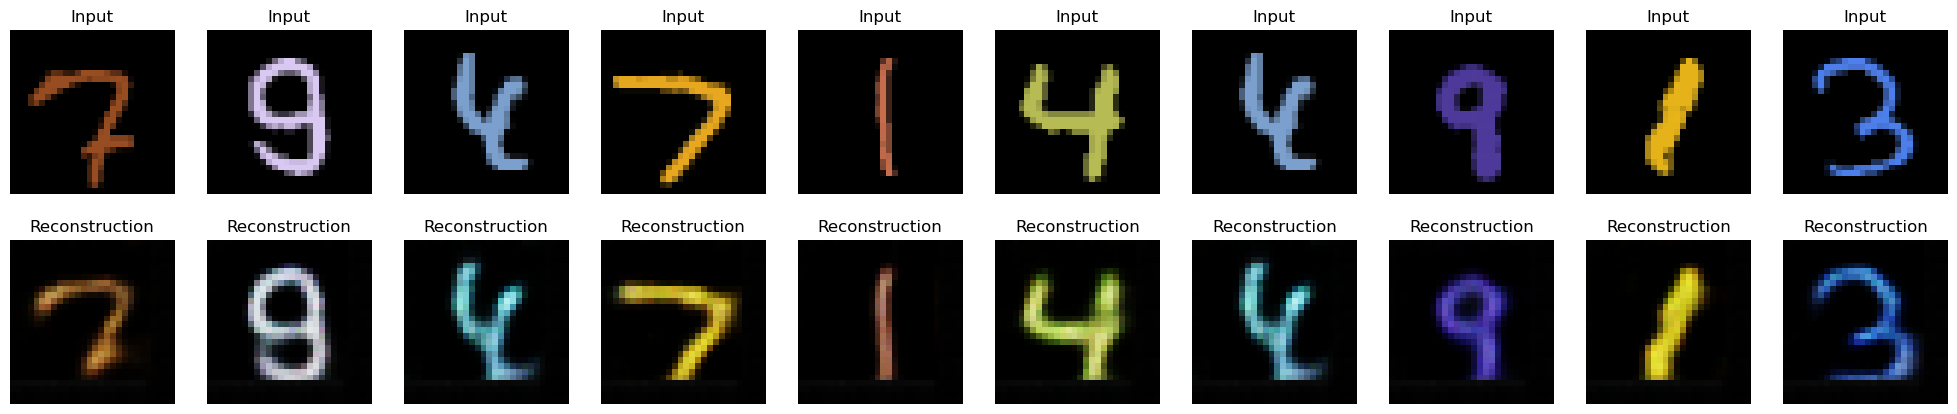

Epoch [9/15], Train Loss: 0.0052, Val Loss: 0.0051


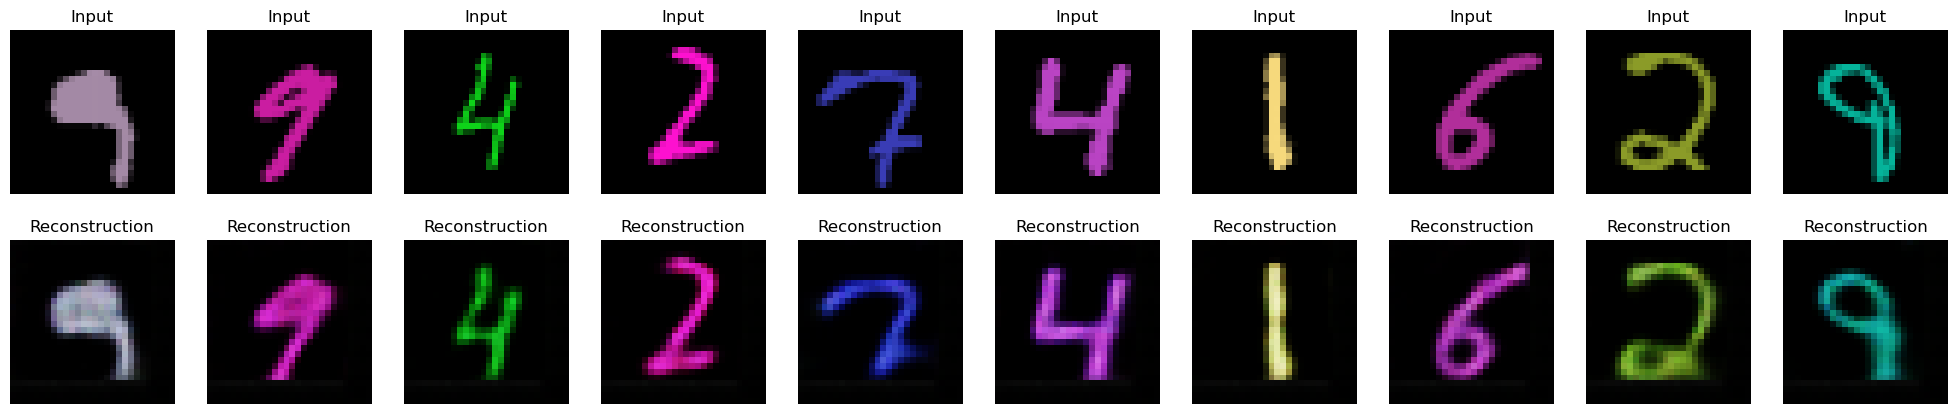

Epoch [12/15], Train Loss: 0.0048, Val Loss: 0.0047


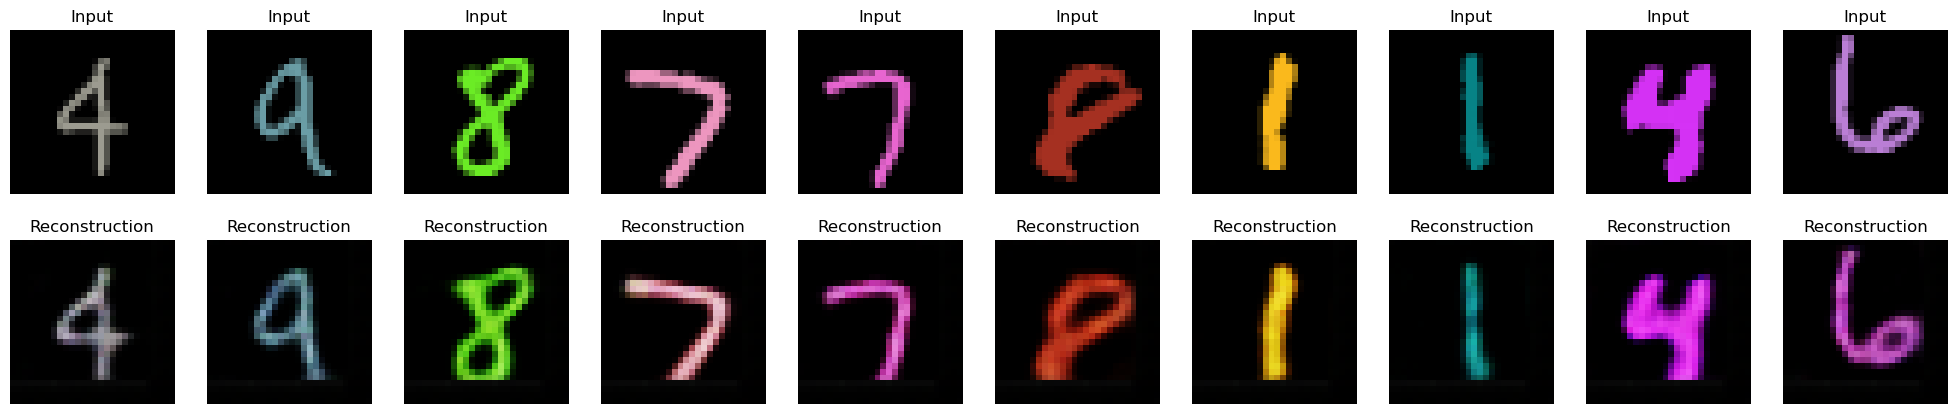

Epoch [15/15], Train Loss: 0.0046, Val Loss: 0.0045


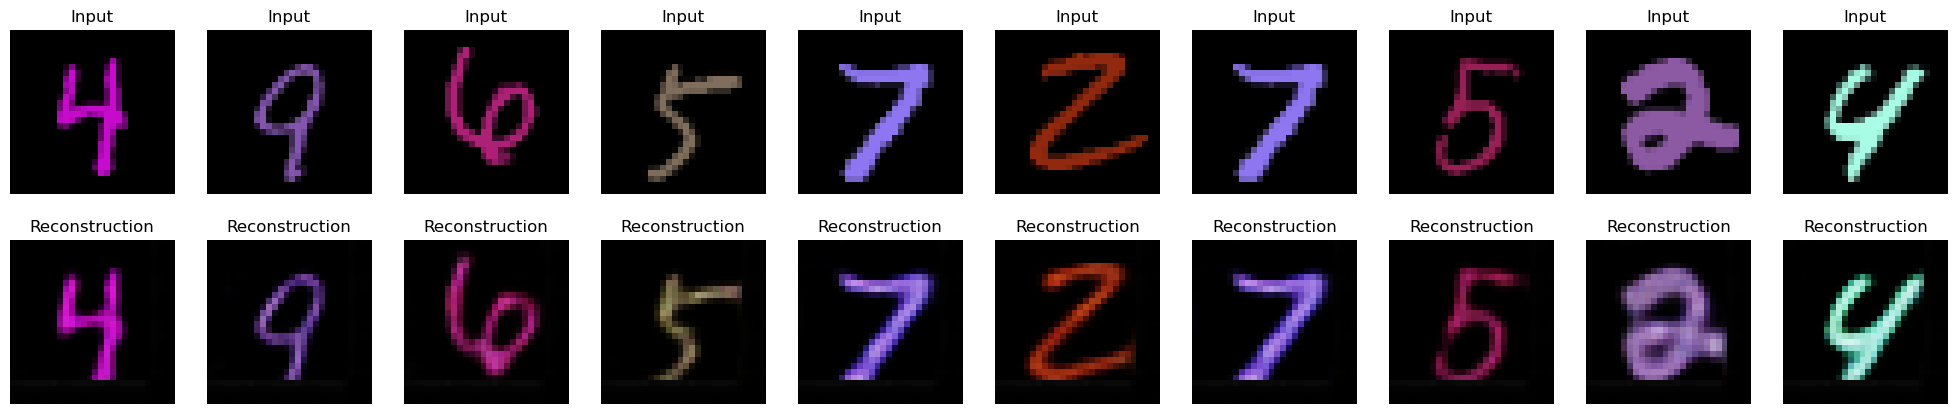

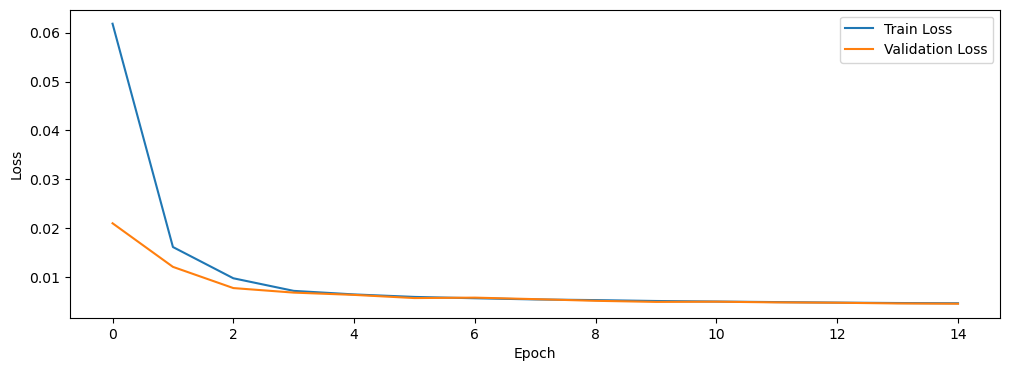

In [145]:
num_epochs = 15
num_samples = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs): 

    vq_vae.train()
    total_train_loss = 0.0
    total_train_loss = 0.0

    for batch_data, _ in train_loader:
        optimizer.zero_grad()
        batch_data = batch_data.repeat(1, 3, 1, 1) * torch.rand(batch_data.size(0), 3, 1, 1)
        # Forward pass
        batch_data = batch_data.to(device)
        recon, z_e, z_q = vq_vae(batch_data)
        
        loss = criterion(recon, batch_data) + criterion(z_e.detach(), z_q) + beta * criterion(z_e, z_q.detach())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        codebooks.append(vq_vae.codebook.codebook.weight.detach().cpu())

        total_train_loss += loss.item()

    # Print the loss for each epoch
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model = vq_vae
    model.eval()

        # Get a batch of data
    with torch.no_grad():

        total_val_loss = 0.0

        for batch_data, _ in test_loader:
            batch_data = batch_data.repeat(1, 3, 1, 1) * torch.rand(batch_data.size(0), 3, 1, 1)
            batch_data = batch_data.to(device)
            recon, z_e, z_q = vq_vae(batch_data)
            loss = criterion(recon, batch_data) + criterion(z_e.detach(), z_q) + beta * criterion(z_e, z_q.detach())

            total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        
        if (100 * (epoch+1) / num_epochs) % 20 == 0:

            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            
            data, _ = next(iter(test_loader))
            data = data.repeat(1, 3, 1, 1) * torch.rand(data.size(0), 3, 1, 1)
            data = data.to(device)
            recon, _, _ = model(data)
        
            denormalized_data = data
            denormalized_reconstructions = recon

            plt.figure(figsize=(5*num_samples//2, 5))
            samples = torch.randint(0, data.size(0), (num_samples,))
            for i, s in enumerate(samples):
                plt.subplot(2, num_samples, i + 1)
                plt.imshow(denormalized_data[s].permute(1, 2, 0).cpu(), cmap='gray')
                plt.title('Input')
                plt.axis('off')

                plt.subplot(2, num_samples, i + 1 + num_samples)
                plt.imshow(denormalized_reconstructions[s].permute(1, 2, 0).cpu(), cmap='gray')
                plt.title('Reconstruction')
                plt.axis('off')

            plt.show()

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

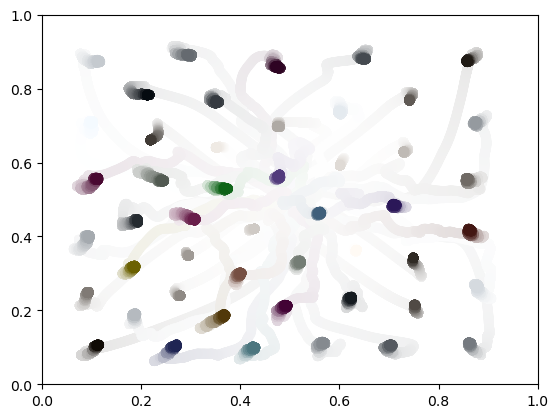

In [146]:
colors = torch.arange(0, 1, 1/codebook_size)
colors2 = colors.__reversed__()
colors3 = torch.rand(codebook_size) / 2 + 0.5
colors = torch.stack([colors, colors2, colors3]).view(-1, 3)

cbs = torch.stack(codebooks)

fig, ax = plt.subplots()

# Function to update the plot for each frame
def update(frame):
    ax.clear()
    plt.scatter(cbs[frame*10, :, 0], cbs[frame*10, :, 1], c=1-colors)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
# Create the animation
ani = FuncAnimation(fig, update, frames=cbs.shape[0]//10, repeat=False)

# Save the animation as a GIF
ani.save('animation_higherLatentDim.gif', writer='pillow', fps=30)

for i, cb in enumerate(cbs):
    plt.scatter(cb[:, 0], cb[:, 1], c=1-colors*(i / cbs.shape[0]))
plt.show()

# Increasing codebook dim

In [147]:
input_dim = 3  # Single-channel images for MNIST
hidden_dim = [64, 64]
latent_channels = 64  # Adjust as needed
codebook_size = 3
codebook_dim = 32 # codebook dim x16
beta = 0.01

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vq_vae = VQVAE(input_dim, hidden_dim, latent_channels, codebook_size, codebook_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(vq_vae.parameters(), lr=0.001)

codebooks = []

Epoch [3/15], Train Loss: 0.0927, Val Loss: 0.0967


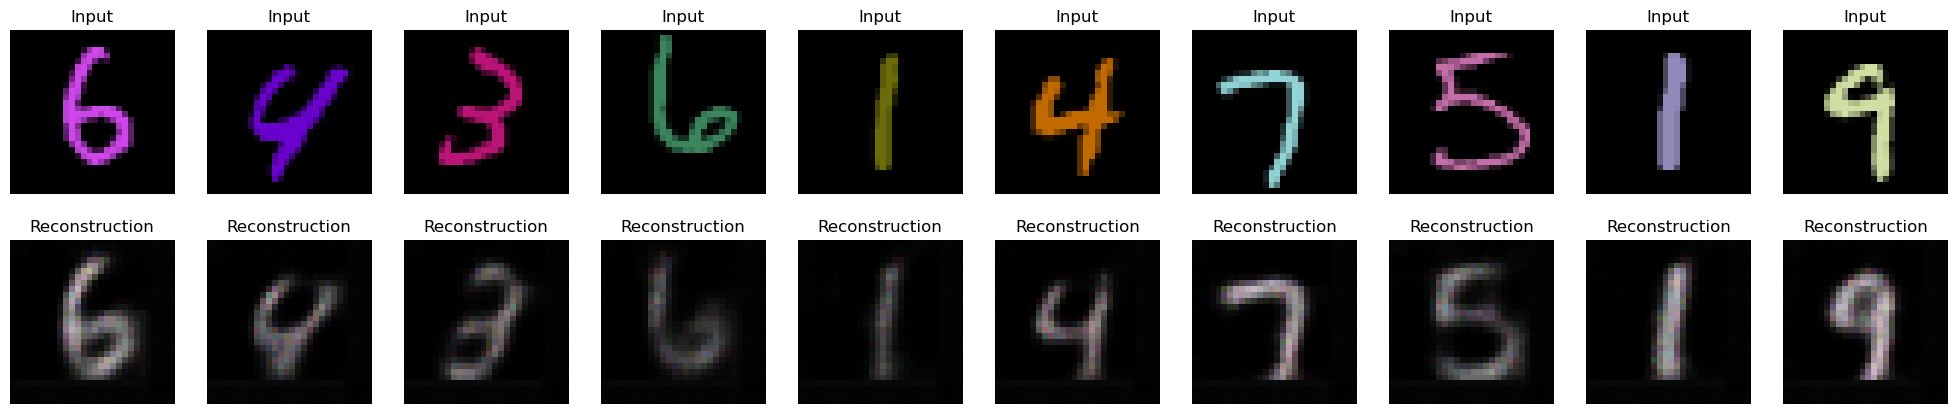

Epoch [6/15], Train Loss: 0.1111, Val Loss: 0.1122


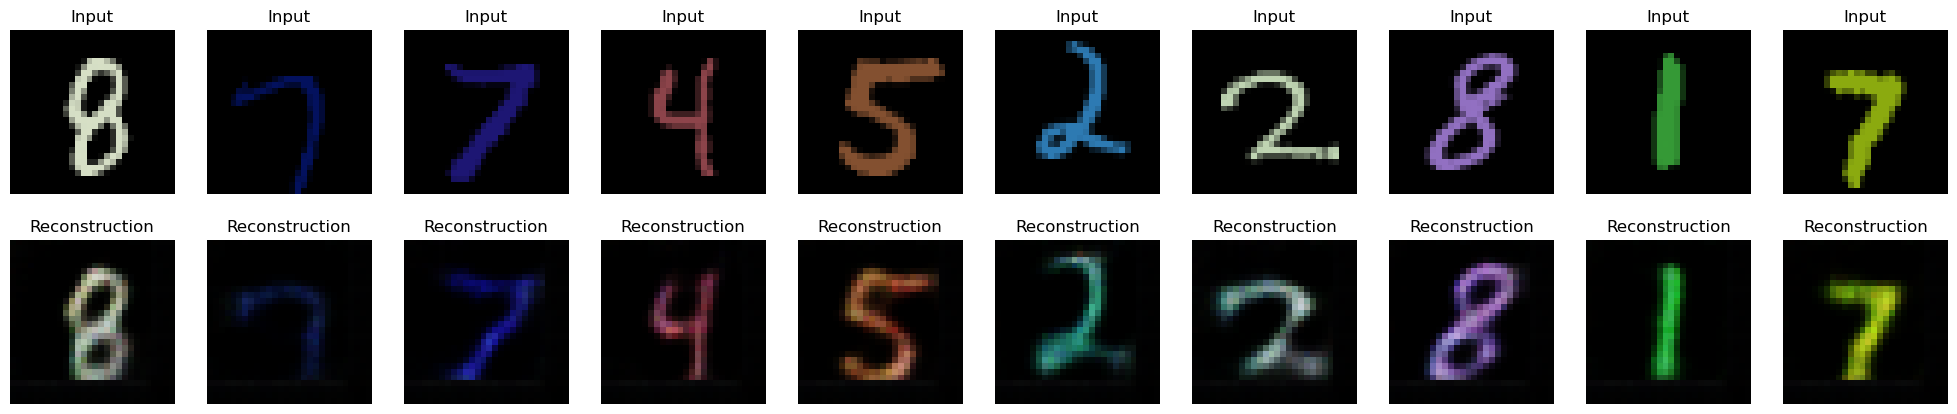

Epoch [9/15], Train Loss: 0.1079, Val Loss: 0.1079


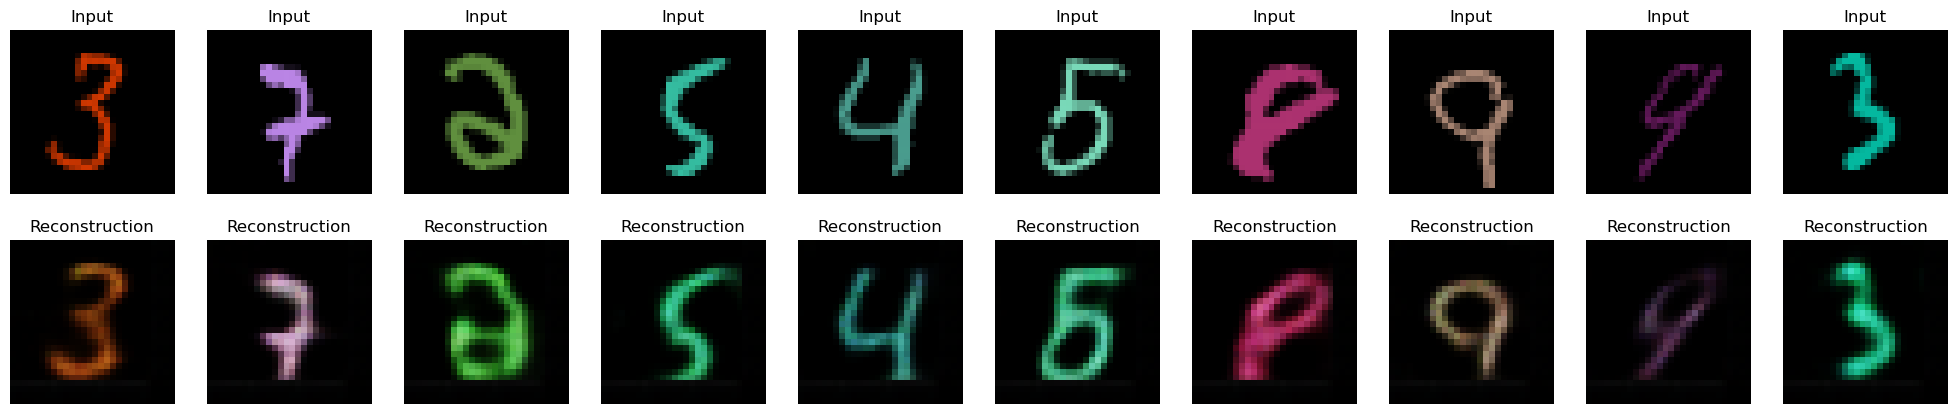

Epoch [12/15], Train Loss: 0.1038, Val Loss: 0.1040


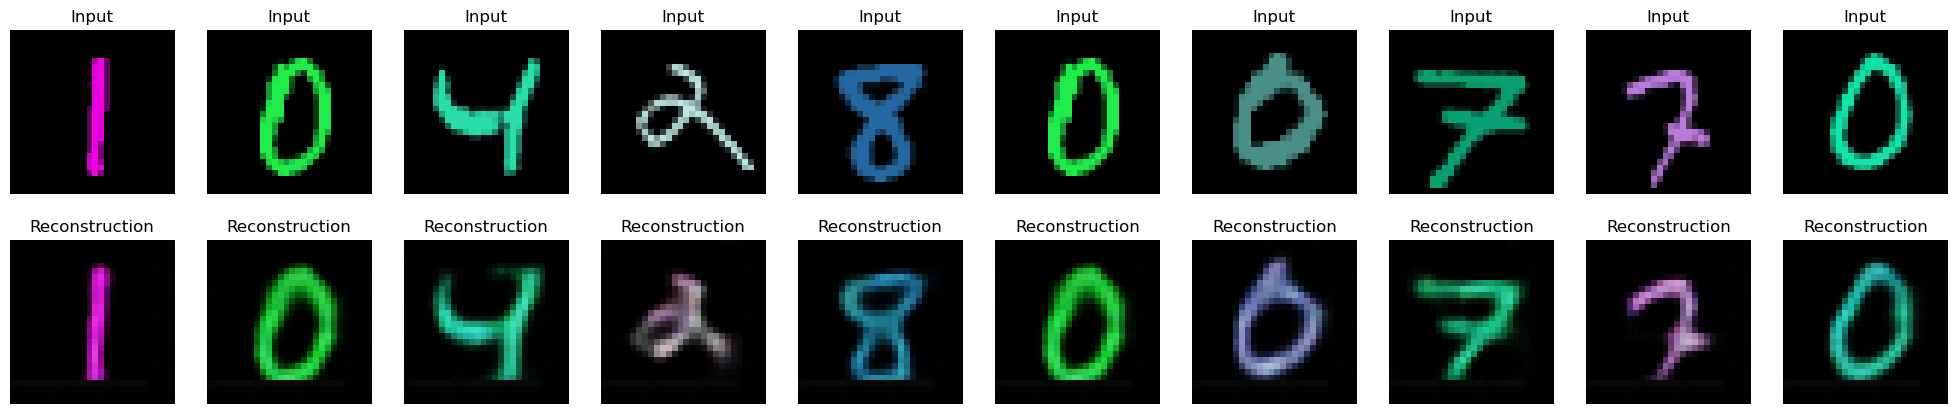

Epoch [15/15], Train Loss: 0.1003, Val Loss: 0.1007


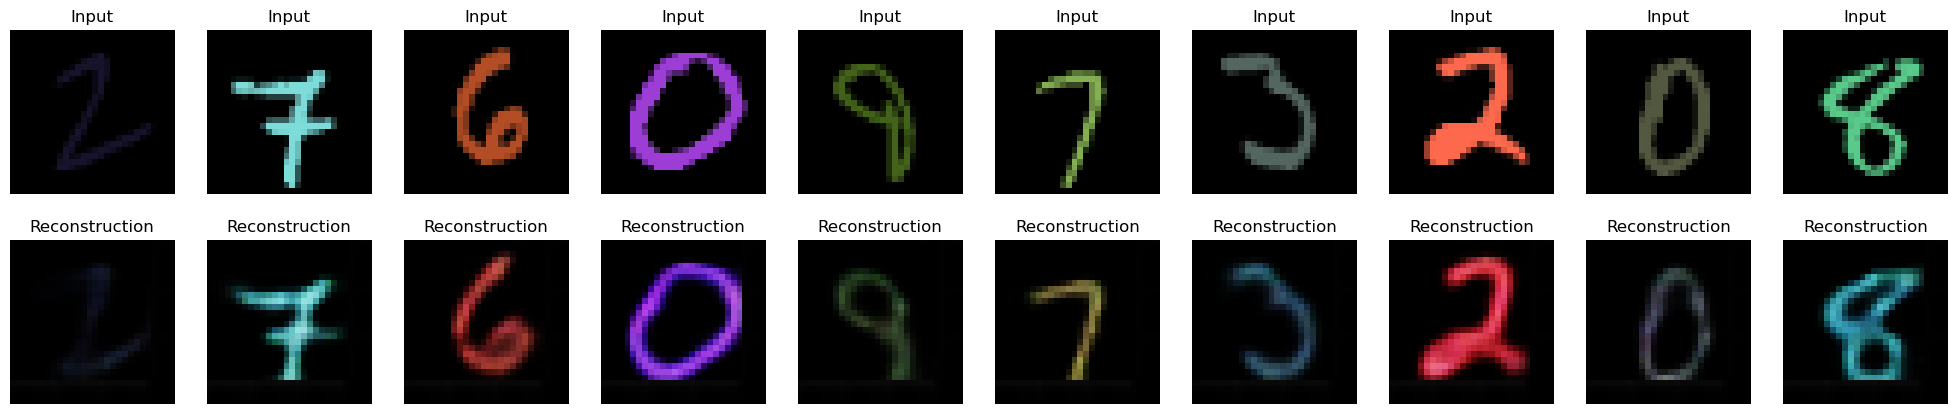

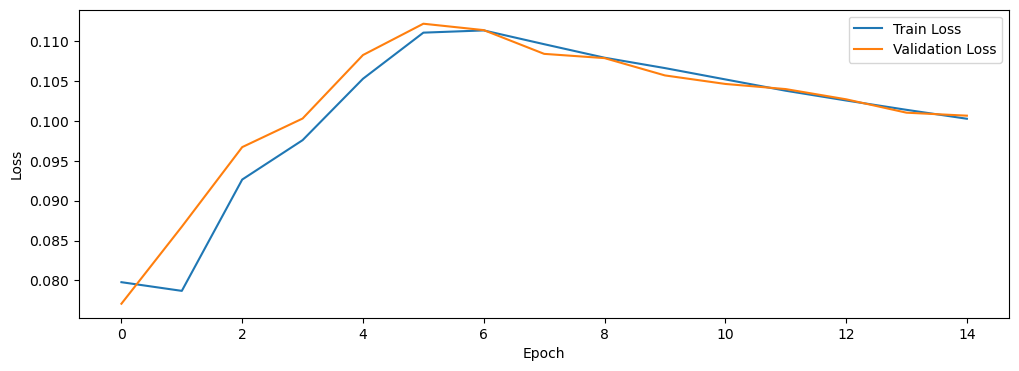

In [148]:
num_epochs = 15
num_samples = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs): 

    vq_vae.train()
    total_train_loss = 0.0
    total_train_loss = 0.0

    for batch_data, _ in train_loader:
        optimizer.zero_grad()
        batch_data = batch_data.repeat(1, 3, 1, 1) * torch.rand(batch_data.size(0), 3, 1, 1)
        # Forward pass
        batch_data = batch_data.to(device)
        recon, z_e, z_q = vq_vae(batch_data)
        
        loss = criterion(recon, batch_data) + criterion(z_e.detach(), z_q) + beta * criterion(z_e, z_q.detach())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        codebooks.append(vq_vae.codebook.codebook.weight.detach().cpu())

        total_train_loss += loss.item()

    # Print the loss for each epoch
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model = vq_vae
    model.eval()

        # Get a batch of data
    with torch.no_grad():

        total_val_loss = 0.0

        for batch_data, _ in test_loader:
            batch_data = batch_data.repeat(1, 3, 1, 1) * torch.rand(batch_data.size(0), 3, 1, 1)
            batch_data = batch_data.to(device)
            recon, z_e, z_q = vq_vae(batch_data)
            loss = criterion(recon, batch_data) + criterion(z_e.detach(), z_q) + beta * criterion(z_e, z_q.detach())

            total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        
        if (100 * (epoch+1) / num_epochs) % 20 == 0:

            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            
            data, _ = next(iter(test_loader))
            data = data.repeat(1, 3, 1, 1) * torch.rand(data.size(0), 3, 1, 1)
            data = data.to(device)
            recon, _, _ = model(data)
        
            denormalized_data = data
            denormalized_reconstructions = recon

            plt.figure(figsize=(5*num_samples//2, 5))
            samples = torch.randint(0, data.size(0), (num_samples,))
            for i, s in enumerate(samples):
                plt.subplot(2, num_samples, i + 1)
                plt.imshow(denormalized_data[s].permute(1, 2, 0).cpu(), cmap='gray')
                plt.title('Input')
                plt.axis('off')

                plt.subplot(2, num_samples, i + 1 + num_samples)
                plt.imshow(denormalized_reconstructions[s].permute(1, 2, 0).cpu(), cmap='gray')
                plt.title('Reconstruction')
                plt.axis('off')

            plt.show()

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

As we can see, The loss decreases with increasing codebook size but it increases with codebook dim (there is an optimum codebook dim for one specific model, and increasing it more than enough can cause hard training situation). So, increasing complexity in dimention of codebook is harmful for training and decreases model solving power. Increment in codebook size is key of more accurate estimation.